<a href="https://colab.research.google.com/github/hikmatussholehah23/TUBES-AI_KELOMPOK-2/blob/main/klasifikasi_daun_dan_buah_melon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = '/content/drive/MyDrive/AI/dataset'
data_dir = pathlib.Path(dataset_url)

check jumlah dataset

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

100


mengecek buah

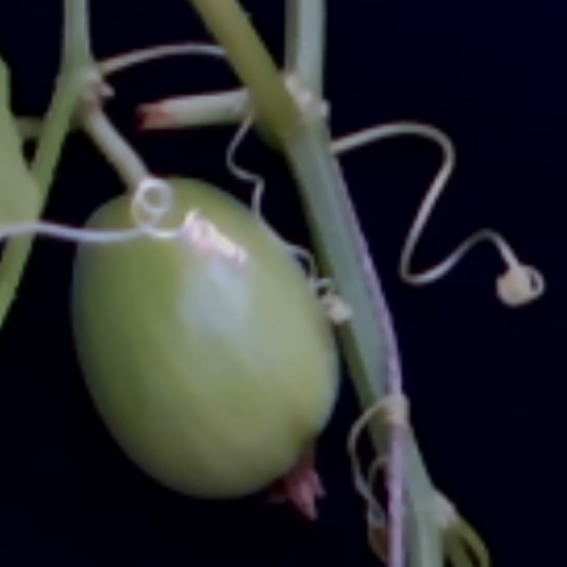

In [ ]:
buah = list(data_dir.glob('buah/*'))
PIL.Image.open(str(buah[0]))

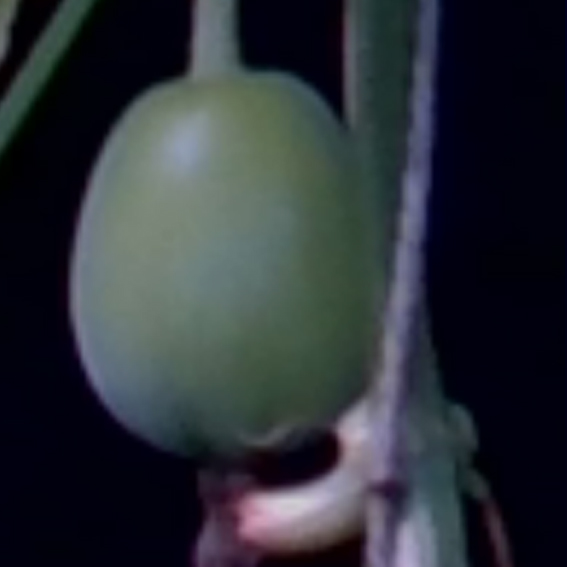

In [ ]:
PIL.Image.open(str(buah[1]))

And some tulips:

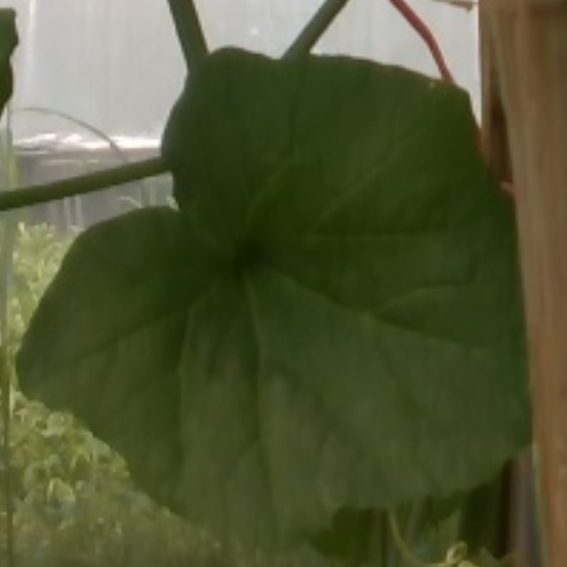

In [ ]:
daun = list(data_dir.glob('daun/*'))
PIL.Image.open(str(daun[0]))

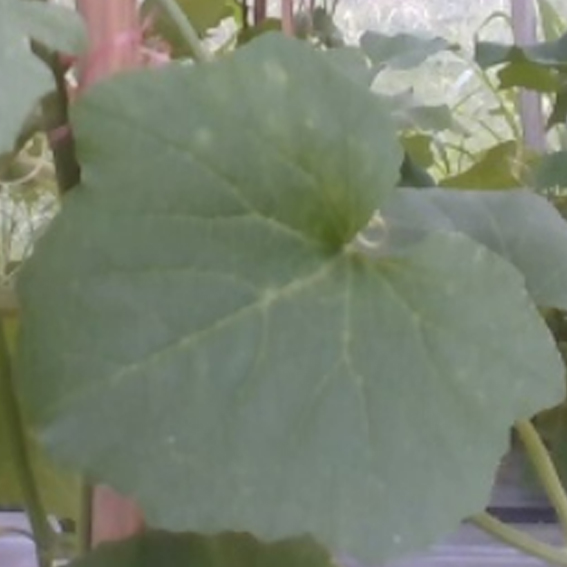

In [ ]:
PIL.Image.open(str(daun[1]))

## Create a dataset

menentukan beberapa parameter untuk loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

melakukan pemisahan validasi saat mengembangkan model. dengan menggunakan 80% dari gambar untuk pelatihan, dan 20% untuk validasi.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.
Using 80 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.
Using 20 files for validation.


menemukan nama kelas di atribut class_names pada kumpulan data ini. Ini sesuai dengan nama direktori dalam urutan abjad.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['buah', 'daun']


terdapat sembilan gambar pertama dari dataset pelatihan:

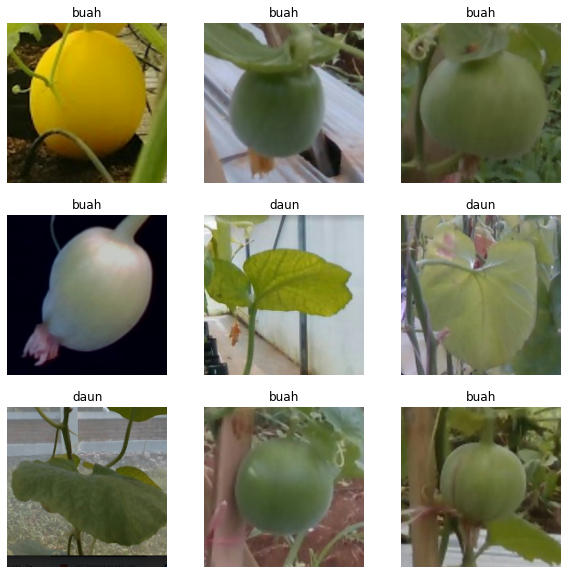

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

melatih model menggunakan kumpulan data ini dengan meneruskannya ke Model.fit 

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

Model Sequential terdiri dari tiga blok konvolusi ( tf.keras.layers.Conv2D ) dengan lapisan pooling maks ( tf.keras.layers.MaxPooling2D ) di masing-masing blok. Ada lapisan yang sepenuhnya terhubung ( tf.keras.layers.Dense ) dengan 128 unit di atasnya yang diaktifkan oleh fungsi aktivasi ReLU ( 'relu' ). Model ini belum disetel untuk akurasi tinggi—tujuan dari tutorial ini adalah untuk menunjukkan pendekatan standar.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.
(Untuk melihat akurasi pelatihan dan validasi untuk setiap periode pelatihan)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

melihat lapisan jaringan menggunakan metode Model.summary model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
epochs=180
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[EarlyStopping(monitor='val_loss', patience=3, mode='auto')]

)

Epoch 1/180
3/3 [==============================] - 0s 34ms/step - loss: 1.0052e-05 - accuracy: 1.0000 - val_loss: 1.3639 - val_accuracy: 0.8500
Epoch 2/180
3/3 [==============================] - 0s 32ms/step - loss: 9.9492e-06 - accuracy: 1.0000 - val_loss: 1.3651 - val_accuracy: 0.8500
Epoch 3/180
3/3 [==============================] - 0s 32ms/step - loss: 9.8658e-06 - accuracy: 1.0000 - val_loss: 1.3668 - val_accuracy: 0.8500
Epoch 4/180
3/3 [==============================] - 0s 31ms/step - loss: 9.7749e-06 - accuracy: 1.0000 - val_loss: 1.3685 - val_accuracy: 0.8500


## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

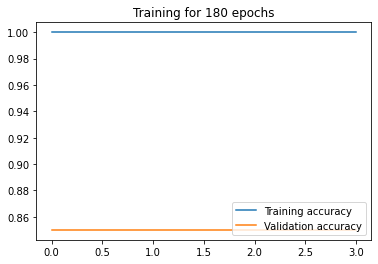

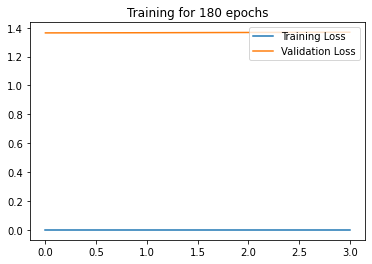

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_path = '/content/drive/MyDrive/AI/test/buah/b_1.png'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to buah with a 100.00 percent confidence.
